# Life-time Broadened Case

This is the code for the cold vapor cell. In this code, the decay from states 1 and 2 is set to 0 but can be modified.

### Libraries

In [1]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.linalg import LinAlgError, solve
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

### Parameters

In [2]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2 + 1e-3 * Gamma3   # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
w0 = 71e-6          # In m
L = 0.02        # Length in meters
z = 0.000025    # Step size in meters

OD_0 = 50
N = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * 10**6 * hbar * epsilon_0 * 795e-9))

print("Atomic Density (OD0={:.2f}) = {:.2e}".format(OD_0, N))

Atomic Density (OD0=50.00) = 2.98e+16


## Main Code

In [61]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 250
    Om_2_list_adapted = np.linspace(0.0, 5 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(0, len(Om_2_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            # Construct A and b to compute matrix linear solution
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            try:
                v = solve(A, b)
            except LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue


            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = rho11
            rho22_values[i][j] = rho22
            rho33_values[i][j] = rho33
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / 1e6
        

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

def plot_OD(Om_1, delta_1, delta_2):
    global Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted
    Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Calculate Power of I_1
    w0 = 71e-6          # In m
    P = (np.pi * c * epsilon_0 * (Om_1*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    print("Power required = {:.2e} W".format(P))
    
    # Calculate input and output intensity
    Input_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (Om_1 * 1e6 * hbar / mu_13)**2
    Input_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (Om_2_list_adapted * 1e6 * hbar / mu_23)**2  
    
    print("Input I1 = {:.2e}".format(Input_Intensity_Omega_1))

    Output_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :]) * 1e6 * hbar / mu_13)**2
    Output_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :]) * 1e6 * hbar / mu_23)**2  
    
    ###############
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted)**2, np.abs(Om_1_vs_z[-1, :])**2, color='blue', label=r'Output Intensity $\Omega_1$')
    plt.xlabel(r'$\Omega_{2,\mathrm{in}}$')
    plt.ylabel(r'$\Omega_{1,\mathrm{out}}$')
    plt.title(r'$\Omega_{1,\mathrm{out}}$ vs variable $\Omega_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted)**2, np.abs(Om_2_vs_z[-1, :])**2, color='red', label=r'Output Intensity $\Omega_2$')
    plt.xlabel(r'$\Omega_{2,\mathrm{in}}$')
    plt.ylabel(r'$\Omega_{2,\mathrm{out}}$')
    plt.title(r'$\Omega_{2,\mathrm{out}}$ vs variable $\Omega_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.show()
    
    ##############
    
    # Plot Output Intensity 1 vs Initial Intensity 2
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2, Output_Intensity_Omega_1, color='blue', label=f'OD_0={OD_0}\n$I_{{1,\t{{in}}}}$={Input_Intensity_Omega_1:.2e} $(W/m^2)$\n$\\Delta_1$={delta_1} (MHz)\n$\\Delta_2$={delta_2} (MHz)')
    plt.xlabel(r'Initial Intensity 2 ($I_{{2,\t{{in}}}}$) $(W/m^2)$')
    plt.ylabel(r'Output Intensity 1 ($I_{{1,\t{{out}}}}$) $(W/m^2)$')
    plt.title(r'$I_{1,\mathrm{out}}$ vs variable $I_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Intensity 2 vs Initial Intensity 2
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2, Output_Intensity_Omega_2, color='red', label=f'OD_0={OD_0}\n$I_{{1,\t{{in}}}}$={Input_Intensity_Omega_1:.2e} $(W/m^2)$\n$\\Delta_1$={delta_1} (MHz)\n$\\Delta_2$={delta_2} (MHz)')
    plt.xlabel(r'Initial Intensity 2 ($I_{{2,\t{{in}}}}$) $(W/m^2)$')
    plt.ylabel(r'Output Intensity 2 ($I_{{2,\t{{out}}}}$) $(W/m^2)$')
    plt.title(r'$I_{2,\mathrm{out}}$ vs variable $I_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_1, delta_1, delta_2 with wider description layout
Om_1_slider = widgets.FloatSlider(
    value=37.69, min=0.000000001, max=500.0, step=0.000001,
    description=r'$\Omega_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=0.0, min=-50, max=150, step=0.000001,
    description=r'$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=9.4, min=-50, max=150, step=0.00001,
    description=r'$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = Om_1_slider.value
    delta_1 = delta_1_slider.value
    delta_2 = delta_2_slider.value
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_1_slider, delta_1_slider, delta_2_slider, run_button)


FloatSlider(value=37.69, description='$\\Omega_1$ (MHz)', layout=Layout(width='800px'), max=500.0, min=1e-09, …

FloatSlider(value=0.0, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, st…

FloatSlider(value=9.4, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, st…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

### Scanning Values

In [3]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 250
    Om_2_list_adapted = np.linspace(0, 5 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            # Construct A and b to compute matrix linear solution
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            try:
                v = solve(A, b)
            except LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue


            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = rho11
            rho22_values[i][j] = rho22
            rho33_values[i][j] = rho33
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / 1e6
        

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    Output_Intensity_Omega_1_list = [0]*len(delta_1)
    Output_Intensity_Omega_2_list = [0]*len(delta_1)
    Input_Intensity_Omega_1_list = [0]*len(delta_1)
    Input_Intensity_Omega_2_list = [0]*len(delta_1)
    Output_Power_Omega_1_list = [0]*len(delta_1)
    Output_Power_Omega_2_list = [0]*len(delta_1)
    Input_Power_Omega_1_list = [0]*len(delta_1)
    Input_Power_Omega_2_list = [0]*len(delta_1)
        
    # Calculate Power of I_1
    P = (np.pi * c * epsilon_0 * (Om_1*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i])
        # Calculate input and output intensity 
        
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_2$={delta_2[i]:.2f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure3b2.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax2.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_2$={delta_2[i]:.2f} MHz')

    ax2.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax2.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Top X-axis for input power (still use x_forward / x_inverse for the coupling beam’s dipole moment mu_23):
    ax2_top = ax2.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax2_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Right Y-axis for output power (again use mu_23, because it’s the same beam if it’s $\Omega_2$):
    ax2_right = ax2.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))  
    # or if you want the same function names but with mu_23 inside, define them accordingly.
    ax2_right.set_ylabel('Output Power for $\\Omega_2$ (W)')

    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([1, 1, 1, 1, 1]) * Gamma3
    delta_1 = [0, 0, 0, 0, 0]
    delta_2 = np.array([0, 0.25, 0.5, 0.75, 1]) * Gamma3
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the button
display(run_button)


Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

### Variable laser now Laser1

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 200/800
Processing z step 400/800
Processing z step 600/800
Processing z step 200/800
Processing z step 400/800
Processing z step 600/800
Processing z step 200/800
Processing z step 400/800
Processing z step 600/800
Processing z step 200/800
Processing z step 400/800
Processing z step 600/800
Processing z step 200/800
Processing z step 400/800
Processing z step 600/800


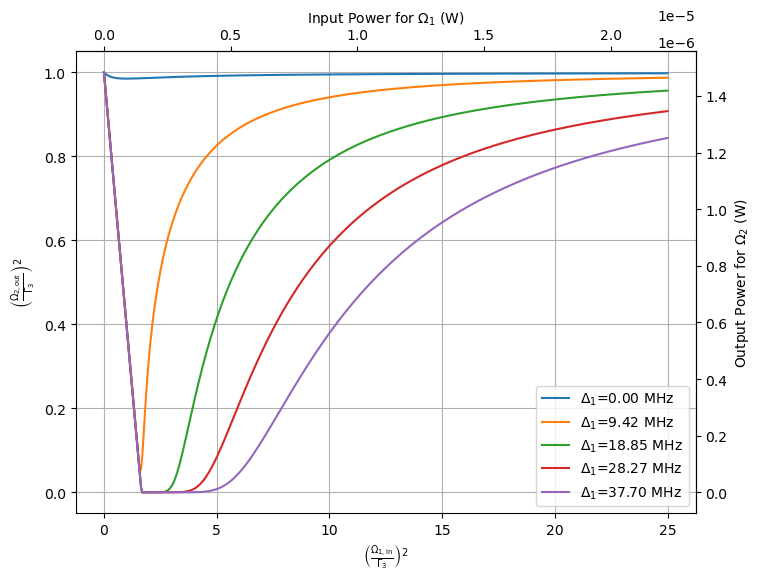

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


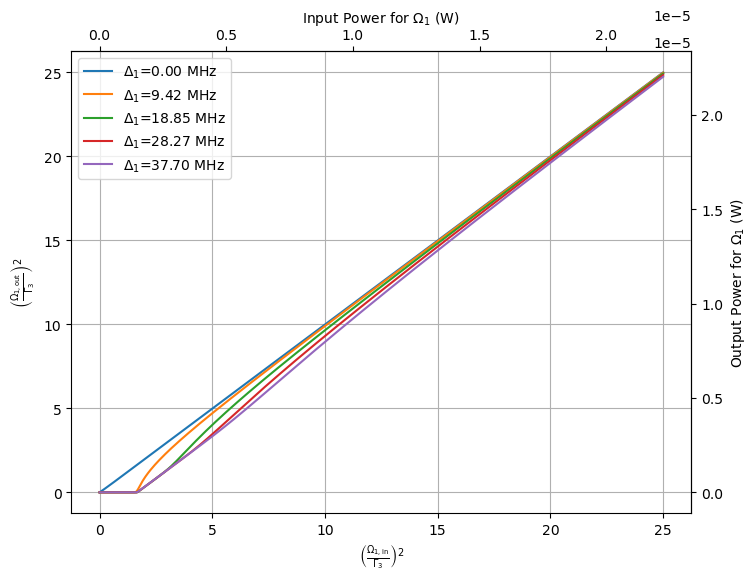

In [4]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 250
    Om_1_list_adapted = np.linspace(0, 5 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(0, len(Om_1_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            # Construct A and b to compute matrix linear solution
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            try:
                v = solve(A, b)
            except LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue


            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = rho11
            rho22_values[i][j] = rho22
            rho33_values[i][j] = rho33
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / 1e6
        

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
def y_forward_2(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2) 
def y_inverse_2(power_value):
    return power_value / (K_1 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
        
    # Calculate Power of I_1
    P = (np.pi * c * epsilon_0 * (Om_2*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i])
        # Calculate input and output intensity 
        
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.2f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_1:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Create the right Y-axis for power of Omega_2:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_2$ (W)')
    plt.show()

    fig, ax2 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax2.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.2f} MHz')

    ax2.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax2.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Top X-axis for input power (still use x_forward / x_inverse for the coupling beam’s dipole moment mu_23):
    ax2_top = ax2.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax2_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Right Y-axis for output power (again use mu_23, because it’s the same beam if it’s $\Omega_2$):
    ax2_right = ax2.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))  
    ax2_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure3c(same scale).pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([1, 1, 1, 1, 1]) * Gamma3
    delta_1 = np.array([0, 0.25, 0.5, 0.75, 1]) * Gamma3
    delta_2 = [0, 0, 0, 0, 0]
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the button
display(run_button)


### Maximum absorption ReLU

Variable Om_2

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Processing z step 50/200
Processing z step 100/200
Processing z step 150/200


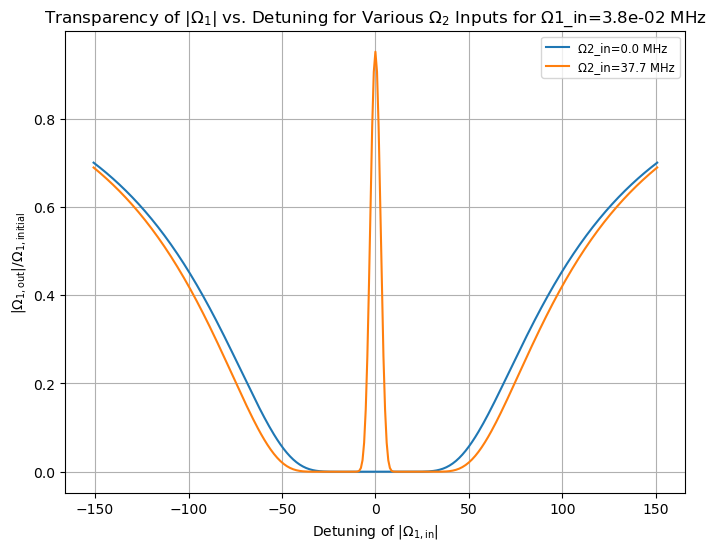

In [81]:
def calculate_OD_1(Om_2=1.0, last_omega=1):
    n_detunings = 351
    Om_1_list = np.full(n_detunings, 0.001 * Gamma3, dtype=complex)
    Om_2_list = np.full(n_detunings, Om_2, dtype=complex)
    Om_1_initial = Om_1_list[0]
    Om_2_initial = Om_2_list[0]
    
    detuning_list = np.linspace(-4000 * Om_1_initial, 4000 * Om_1_initial, n_detunings, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_detunings), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_detunings), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_detunings), dtype=float)
    rho22_values = np.zeros((nz, n_detunings), dtype=float)
    rho33_values = np.zeros((nz, n_detunings), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_detunings), dtype=complex)
    rho32_values = np.zeros((nz, n_detunings), dtype=complex)
    
    Om_2_actual = 0 + 0j
    Om_1_actual = 0 + 0j

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(detuning_list)):
            
            Om_2_actual = Om_2_list[j]    
            Om_1_actual = Om_1_list[j]      

            # We'll just vary delta_2 here:
            delta_2_actual = 0
            delta_1_actual = detuning_list[j]

            I = 1j  # imaginary unit

            # Construct the matrix A
            A = np.array([
                [Gamma31 + Gamma12, 0,                I*Om_1_actual/2,             0,
                 Gamma31 - Gamma21, 0,               -I*np.conjugate(Om_1_actual)/2,  0],
                
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0,
                 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0,
                 I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual),
                 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                
                [Gamma32 - Gamma12, 0, 0, 0,
                 Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2,
                 I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2,
                 -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0,
                 -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            
            try:
                v = solve(A, b)
            except LinAlgError:
                print("nan")
                rho11_values[i, j] = np.nan
                rho22_values[i, j] = np.nan
                rho33_values[i, j] = np.nan
                rho31_values[i, j] = np.nan
                rho32_values[i, j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho22 = np.real(v[4])
            rho33 = 1 - rho11 - rho22
            rho31 = v[6]
            rho32 = v[7]

            # Store populations
            rho11_values[i, j] = rho11
            rho22_values[i, j] = rho22
            rho33_values[i, j] = rho33
            rho31_values[i, j] = rho31
            rho32_values[i, j] = rho32
            
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j)*(k_1/(epsilon_0*hbar))*N*rho31*(mu_13**2)/1e6
            Om_2_list[j] = Om_2_actual + z * (1j)*(k_2/(epsilon_0*hbar))*N*rho32*(mu_23**2)/1e6
        
        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    return (Om_2_list, Om_1_list,
            rho11_values, rho22_values, rho33_values,
            rho31_values, rho32_values,
            Om_2_vs_z, Om_1_vs_z,
            z_array, detuning_list,
            Om_1_initial, Om_2_initial)

# ------------------------------------------------------------
# Plot function that iterates over multiple Omega1 values
# ------------------------------------------------------------
def plot_OD():
    """
    This function loops over a list of five different Ω1 values, 
    calls calculate_OD_1 for each, and plots all curves on the same axes.
    """
    # Define a list of five different Omega1 values
    omega2_list = np.array([0.001, 1])*Gamma3
    
    # Ensure text is stored as text (not outlines) in the PDF
    mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
    mpl.rcParams['ps.fonttype'] = 42   # Same for PostScript/EPS

    plt.figure(figsize=(8, 6))
    
    for Om_2 in omega2_list:
        # Run the calculation
        (Om_2_list, Om_1_list,
         rho11_values, rho22_values, rho33_values,
         rho31_values, rho32_values,
         Om_2_vs_z, Om_1_vs_z,
         z_array, detuning_list,
         Om_1_initial, Om_2_initial) = calculate_OD_1(Om_2, omega2_list[-1])

        # Plot the final Ω1 (last z-step) normalized by its initial value
        label_str = f"Ω2_in={np.abs(Om_2):.1f} MHz"
        plt.plot(
            detuning_list,
            np.abs(Om_1_vs_z[-1, :]) / np.abs(Om_1_initial),
            label=label_str
        )

    # Properly formatted title and labels
    plt.title(
        fr"Transparency of $|\Omega_{{1}}|$ vs. Detuning for Various $\Omega_2$ Inputs "
        fr"for Ω1_in={np.abs(Om_1_initial):.1e} MHz"
    )
    plt.xlabel(r"Detuning of $|\Omega_{1,\mathrm{in}}|$")
    plt.ylabel(r"$|\Omega_{1,\mathrm{out}}| / \Omega_{1,\mathrm{initial}}$")
    plt.grid(True)
    plt.legend(loc='upper right', fontsize='small', ncol=1)
    
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure2a.pdf"
    plt.savefig(save_path, format='pdf', dpi=300)

    plt.show()

# ------------------------------------------------------------
# Create and display the "Run Simulation" button
# ------------------------------------------------------------
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

def run_simulation(b):
    """
    Clicking this button will run the plot_OD function.
    """
    plot_OD()

run_button.on_click(run_simulation)

display(run_button)

Variable Om_1

In [11]:
def calculate_OD_1(Om_1=1.0, last_omega=1):
    n_detunings = 751
    Om_2_list = np.full(n_detunings, 0.01 * Gamma3, dtype=complex)
    Om_1_list = np.full(n_detunings, Om_1, dtype=complex)
    Om_1_initial = Om_1_list[0]
    Om_2_initial = Om_2_list[0]
    
    detuning_list = np.linspace(-1.5 * last_omega, 1.5 * last_omega, n_detunings, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_detunings), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_detunings), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_detunings), dtype=float)
    rho22_values = np.zeros((nz, n_detunings), dtype=float)
    rho33_values = np.zeros((nz, n_detunings), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_detunings), dtype=complex)
    rho32_values = np.zeros((nz, n_detunings), dtype=complex)
    
    Om_2_actual = 0 + 0j
    Om_1_actual = 0 + 0j

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(detuning_list)):
            
            Om_2_actual = Om_2_list[j]    
            Om_1_actual = Om_1_list[j]      

            # We'll just vary delta_2 here:
            delta_1_actual = 0
            delta_2_actual = detuning_list[j]

            I = 1j  # imaginary unit

            # Construct the matrix A
            A = np.array([
                [Gamma31 + Gamma12, 0,                I*Om_1_actual/2,             0,
                 Gamma31 - Gamma21, 0,               -I*np.conjugate(Om_1_actual)/2,  0],
                
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0,
                 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0,
                 I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual),
                 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                
                [Gamma32 - Gamma12, 0, 0, 0,
                 Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2,
                 I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2,
                 -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0,
                 -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            
            try:
                v = solve(A, b)
            except LinAlgError:
                print("nan")
                rho11_values[i, j] = np.nan
                rho22_values[i, j] = np.nan
                rho33_values[i, j] = np.nan
                rho31_values[i, j] = np.nan
                rho32_values[i, j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho22 = np.real(v[4])
            rho33 = 1 - rho11 - rho22
            rho31 = v[6]
            rho32 = v[7]

            # Store populations
            rho11_values[i, j] = rho11
            rho22_values[i, j] = rho22
            rho33_values[i, j] = rho33
            rho31_values[i, j] = rho31
            rho32_values[i, j] = rho32
            
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j)*(k_1/(epsilon_0*hbar))*N*rho31*(mu_13**2)/1e6
            Om_2_list[j] = Om_2_actual + z * (1j)*(k_2/(epsilon_0*hbar))*N*rho32*(mu_23**2)/1e6
        
        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    return (Om_2_list, Om_1_list,
            rho11_values, rho22_values, rho33_values,
            rho31_values, rho32_values,
            Om_2_vs_z, Om_1_vs_z,
            z_array, detuning_list,
            Om_1_initial, Om_2_initial)

# ------------------------------------------------------------
# Plot function that iterates over multiple Omega1 values
# ------------------------------------------------------------
def plot_OD():
    """
    This function loops over a list of five different Ω1 values, 
    calls calculate_OD_1 for each, and plots all curves on the same axes.
    """
    # Define a list of five different Omega1 values
    omega1_list = np.array([0.1, 0.5, 1.0, 1.5])*Gamma3
    
    plt.figure(figsize=(8, 6))
    
    for Om_1 in omega1_list:
        # Run the calculation
        (Om_2_list, Om_1_list,
         rho11_values, rho22_values, rho33_values,
         rho31_values, rho32_values,
         Om_2_vs_z, Om_1_vs_z,
         z_array, detuning_list,
         Om_1_initial, Om_2_initial) = calculate_OD_1(Om_1, omega1_list[-1])
        
        # Get the index of the minimum magnitude:
        min_index = np.argmin(np.abs(Om_2_vs_z[-1, :]))
        print(f"The minimum of |Omega_2| is at detuning = {np.abs(detuning_list[min_index]):.1f}")

        # Plot the final Ω1 (last z-step) normalized by its initial value
        label_str = f"Ω1_in={Om_1:.1f} MHz, Ω2_in={np.abs(Om_2_initial):.1f}"
        plt.plot(
            detuning_list,
            np.abs(Om_2_vs_z[-1, :]) / np.abs(Om_2_initial),
            label=label_str
        )

    plt.xlabel(r"Detuning of $|\Omega_{2,\mathrm{out}}|$")
    plt.ylabel(r"$|\Omega_{2,\mathrm{out}}| / \Omega_{2,\mathrm{initial}}$")
    plt.title(r"Transparency of $|\Omega_{2}|$ vs. Detuning for Various $\Omega_1$ Inputs")
    plt.grid(True)
    plt.legend()
    plt.show()

# ------------------------------------------------------------
# Create and display the "Run Simulation" button
# ------------------------------------------------------------
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

def run_simulation(b):
    """
    Clicking this button will run the plot_OD function.
    """
    plot_OD()

run_button.on_click(run_simulation)

display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

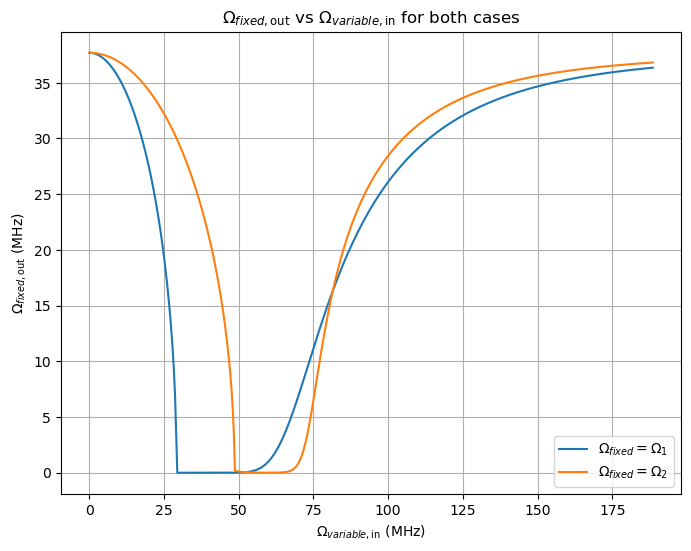

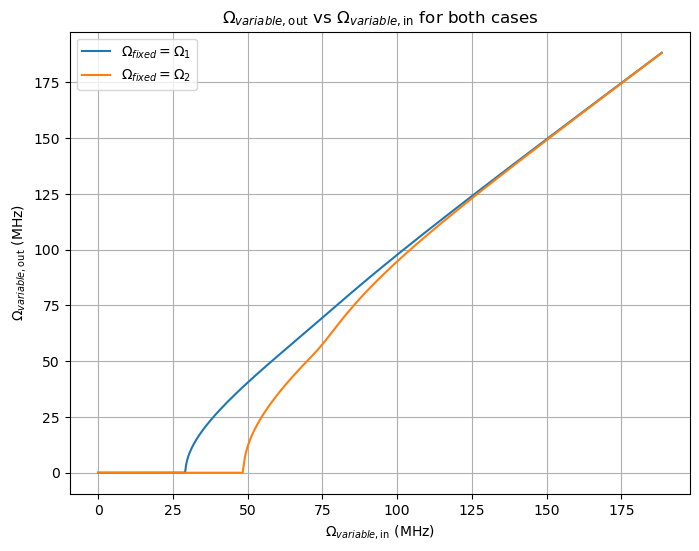

In [40]:
Om_2_list_adapted2 = np.linspace(0, 5 * Gamma3, 500, dtype=complex)  # Coupling Rabi frequency range (MHz)
Output_Omega_1_list2 = [3.76991118e+01, 3.76958968e+01, 3.76862504e+01, 3.76701691e+01,
       3.76476466e+01, 3.76186744e+01, 3.75832411e+01, 3.75413330e+01,
       3.74929332e+01, 3.74380223e+01, 3.73765775e+01, 3.73085731e+01,
       3.72339800e+01, 3.71527656e+01, 3.70648937e+01, 3.69703244e+01,
       3.68690134e+01, 3.67609126e+01, 3.66459693e+01, 3.65241264e+01,
       3.63953217e+01, 3.62594880e+01, 3.61165530e+01, 3.59664387e+01,
       3.58090611e+01, 3.56443303e+01, 3.54721496e+01, 3.52924158e+01,
       3.51050183e+01, 3.49098387e+01, 3.47067508e+01, 3.44956195e+01,
       3.42763006e+01, 3.40486402e+01, 3.38124737e+01, 3.35676255e+01,
       3.33139077e+01, 3.30511196e+01, 3.27790463e+01, 3.24974578e+01,
       3.22061077e+01, 3.19047314e+01, 3.15930449e+01, 3.12707429e+01,
       3.09374963e+01, 3.05929504e+01, 3.02367217e+01, 2.98683952e+01,
       2.94875206e+01, 2.90936081e+01, 2.86861242e+01, 2.82644854e+01,
       2.78280522e+01, 2.73761215e+01, 2.69079170e+01, 2.64225792e+01,
       2.59191515e+01, 2.53965650e+01, 2.48536194e+01, 2.42889584e+01,
       2.37010409e+01, 2.30881029e+01, 2.24481103e+01, 2.17786961e+01,
       2.10770793e+01, 2.03399548e+01, 1.95633431e+01, 1.87423791e+01,
       1.78710063e+01, 1.69415211e+01, 1.59438618e+01, 1.48644466e+01,
       1.36841462e+01, 1.23744465e+01, 1.08893063e+01, 9.14472970e+00,
       6.95080717e+00, 3.57166829e+00, 3.13873407e-06, 7.23328802e-07,
       3.70954553e-07, 2.48842052e-07, 1.91955712e-07, 1.61758300e-07,
       1.45154343e-07, 1.36706958e-07, 1.33915061e-07, 1.35624200e-07,
       1.41409178e-07, 1.51319358e-07, 1.65783526e-07, 1.85599511e-07,
       2.11981419e-07, 2.46658212e-07, 2.92029162e-07, 3.51390659e-07,
       4.29258076e-07, 5.31817639e-07, 6.67557964e-07, 8.48150868e-07,
       1.08967822e-06, 1.41433847e-06, 1.85281649e-06, 2.44756754e-06,
       3.25735559e-06, 4.36350449e-06, 5.87847473e-06, 7.95757754e-06,
       1.08148916e-05, 1.47447657e-05, 2.01506832e-05, 2.75837404e-05,
       3.77935575e-05, 5.17950990e-05, 7.09556255e-05, 9.71068232e-05,
       1.32688024e-04, 1.80927319e-04, 2.46068209e-04, 3.33650177e-04,
       4.50852123e-04, 6.06907844e-04, 8.13602663e-04, 1.08585967e-03,
       1.44242288e-03, 1.90664275e-03, 2.50736695e-03, 3.27993611e-03,
       4.26728014e-03, 5.52110643e-03, 7.10316599e-03, 9.08657865e-03,
       1.15571929e-02, 1.46149510e-02, 1.83752259e-02, 2.29700915e-02,
       2.85494878e-02, 3.52822371e-02, 4.33568716e-02, 5.29822323e-02,
       6.43878010e-02, 7.78237352e-02, 9.35605773e-02, 1.11888622e-01,
       1.33116923e-01, 1.57571952e-01, 1.85595888e-01, 2.17544578e-01,
       2.53785177e-01, 2.94693493e-01, 3.40651079e-01, 3.92042108e-01,
       4.49250078e-01, 5.12654388e-01, 5.82626840e-01, 6.59528118e-01,
       7.43704279e-01, 8.35483327e-01, 9.35171888e-01, 1.04305207e+00,
       1.15937848e+00, 1.28437555e+00, 1.41823507e+00, 1.56111405e+00,
       1.71313296e+00, 1.87437422e+00, 2.04488120e+00, 2.22465749e+00,
       2.41366665e+00, 2.61183230e+00, 2.81903867e+00, 3.03513150e+00,
       3.25991933e+00, 3.49317515e+00, 3.73463841e+00, 3.98401726e+00,
       4.24099117e+00, 4.50521368e+00, 4.77631536e+00, 5.05390694e+00,
       5.33758249e+00, 5.62692268e+00, 5.92149796e+00, 6.22087183e+00,
       6.52460383e+00, 6.83225259e+00, 7.14337855e+00, 7.45754664e+00,
       7.77432863e+00, 8.09330529e+00, 8.41406837e+00, 8.73622222e+00,
       9.05938526e+00, 9.38319116e+00, 9.70728980e+00, 1.00313480e+01,
       1.03550501e+01, 1.06780981e+01, 1.10002122e+01, 1.13211303e+01,
       1.16406083e+01, 1.19584195e+01, 1.22743544e+01, 1.25882203e+01,
       1.28998404e+01, 1.32090538e+01, 1.35157142e+01, 1.38196898e+01,
       1.41208622e+01, 1.44191259e+01, 1.47143876e+01, 1.50065652e+01,
       1.52955876e+01, 1.55813936e+01, 1.58639312e+01, 1.61431575e+01,
       1.64190373e+01, 1.66915431e+01, 1.69606544e+01, 1.72263568e+01,
       1.74886421e+01, 1.77475072e+01, 1.80029541e+01, 1.82549892e+01,
       1.85036230e+01, 1.87488697e+01, 1.89907469e+01, 1.92292752e+01,
       1.94644779e+01, 1.96963807e+01, 1.99250115e+01, 2.01504002e+01,
       2.03725784e+01, 2.05915789e+01, 2.08074363e+01, 2.10201859e+01,
       2.12298641e+01, 2.14365083e+01, 2.16401563e+01, 2.18408466e+01,
       2.20386182e+01, 2.22335102e+01, 2.24255623e+01, 2.26148141e+01,
       2.28013053e+01, 2.29850757e+01, 2.31661650e+01, 2.33446129e+01,
       2.35204588e+01, 2.36937420e+01, 2.38645013e+01, 2.40327756e+01,
       2.41986033e+01, 2.43620224e+01, 2.45230706e+01, 2.46817851e+01,
       2.48382029e+01, 2.49923604e+01, 2.51442936e+01, 2.52940381e+01,
       2.54416289e+01, 2.55871006e+01, 2.57304873e+01, 2.58718228e+01,
       2.60111400e+01, 2.61484717e+01, 2.62838500e+01, 2.64173066e+01,
       2.65488726e+01, 2.66785787e+01, 2.68064550e+01, 2.69325313e+01,
       2.70568366e+01, 2.71793998e+01, 2.73002490e+01, 2.74194120e+01,
       2.75369161e+01, 2.76527880e+01, 2.77670541e+01, 2.78797404e+01,
       2.79908722e+01, 2.81004745e+01, 2.82085720e+01, 2.83151888e+01,
       2.84203486e+01, 2.85240746e+01, 2.86263897e+01, 2.87273165e+01,
       2.88268771e+01, 2.89250930e+01, 2.90219856e+01, 2.91175759e+01,
       2.92118844e+01, 2.93049312e+01, 2.93967363e+01, 2.94873191e+01,
       2.95766986e+01, 2.96648938e+01, 2.97519231e+01, 2.98378046e+01,
       2.99225561e+01, 3.00061952e+01, 3.00887389e+01, 3.01702042e+01,
       3.02506077e+01, 3.03299657e+01, 3.04082941e+01, 3.04856087e+01,
       3.05619250e+01, 3.06372581e+01, 3.07116230e+01, 3.07850342e+01,
       3.08575062e+01, 3.09290531e+01, 3.09996889e+01, 3.10694272e+01,
       3.11382814e+01, 3.12062647e+01, 3.12733900e+01, 3.13396702e+01,
       3.14051178e+01, 3.14697449e+01, 3.15335639e+01, 3.15965865e+01,
       3.16588244e+01, 3.17202891e+01, 3.17809920e+01, 3.18409441e+01,
       3.19001563e+01, 3.19586395e+01, 3.20164041e+01, 3.20734605e+01,
       3.21298189e+01, 3.21854895e+01, 3.22404819e+01, 3.22948060e+01,
       3.23484713e+01, 3.24014871e+01, 3.24538628e+01, 3.25056074e+01,
       3.25567298e+01, 3.26072388e+01, 3.26571430e+01, 3.27064510e+01,
       3.27551712e+01, 3.28033116e+01, 3.28508806e+01, 3.28978859e+01,
       3.29443355e+01, 3.29902371e+01, 3.30355982e+01, 3.30804264e+01,
       3.31247289e+01, 3.31685130e+01, 3.32117858e+01, 3.32545543e+01,
       3.32968255e+01, 3.33386061e+01, 3.33799027e+01, 3.34207220e+01,
       3.34610704e+01, 3.35009543e+01, 3.35403800e+01, 3.35793536e+01,
       3.36178813e+01, 3.36559689e+01, 3.36936225e+01, 3.37308477e+01,
       3.37676503e+01, 3.38040360e+01, 3.38400102e+01, 3.38755784e+01,
       3.39107461e+01, 3.39455184e+01, 3.39799006e+01, 3.40138978e+01,
       3.40475151e+01, 3.40807574e+01, 3.41136297e+01, 3.41461367e+01,
       3.41782833e+01, 3.42100741e+01, 3.42415138e+01, 3.42726068e+01,
       3.43033576e+01, 3.43337708e+01, 3.43638505e+01, 3.43936012e+01,
       3.44230269e+01, 3.44521319e+01, 3.44809204e+01, 3.45093962e+01,
       3.45375634e+01, 3.45654259e+01, 3.45929875e+01, 3.46202522e+01,
       3.46472236e+01, 3.46739054e+01, 3.47003012e+01, 3.47264147e+01,
       3.47522495e+01, 3.47778089e+01, 3.48030964e+01, 3.48281155e+01,
       3.48528694e+01, 3.48773615e+01, 3.49015949e+01, 3.49255730e+01,
       3.49492988e+01, 3.49727755e+01, 3.49960061e+01, 3.50189937e+01,
       3.50417412e+01, 3.50642516e+01, 3.50865278e+01, 3.51085726e+01,
       3.51303889e+01, 3.51519794e+01, 3.51733469e+01, 3.51944941e+01,
       3.52154236e+01, 3.52361380e+01, 3.52566401e+01, 3.52769322e+01,
       3.52970170e+01, 3.53168969e+01, 3.53365744e+01, 3.53560519e+01,
       3.53753317e+01, 3.53944163e+01, 3.54133080e+01, 3.54320090e+01,
       3.54505216e+01, 3.54688480e+01, 3.54869905e+01, 3.55049512e+01,
       3.55227322e+01, 3.55403356e+01, 3.55577636e+01, 3.55750181e+01,
       3.55921013e+01, 3.56090151e+01, 3.56257614e+01, 3.56423423e+01,
       3.56587597e+01, 3.56750153e+01, 3.56911112e+01, 3.57070492e+01,
       3.57228310e+01, 3.57384586e+01, 3.57539335e+01, 3.57692577e+01,
       3.57844328e+01, 3.57994606e+01, 3.58143426e+01, 3.58290807e+01,
       3.58436763e+01, 3.58581312e+01, 3.58724469e+01, 3.58866251e+01,
       3.59006671e+01, 3.59145747e+01, 3.59283493e+01, 3.59419925e+01,
       3.59555056e+01, 3.59688901e+01, 3.59821475e+01, 3.59952793e+01,
       3.60082867e+01, 3.60211713e+01, 3.60339342e+01, 3.60465771e+01,
       3.60591010e+01, 3.60715074e+01, 3.60837976e+01, 3.60959728e+01,
       3.61080343e+01, 3.61199833e+01, 3.61318212e+01, 3.61435491e+01,
       3.61551681e+01, 3.61666796e+01, 3.61780847e+01, 3.61893845e+01,
       3.62005802e+01, 3.62116729e+01, 3.62226637e+01, 3.62335538e+01,
       3.62443441e+01, 3.62550359e+01, 3.62656302e+01, 3.62761279e+01,
       3.62865302e+01, 3.62968381e+01, 3.63070525e+01, 3.63171746e+01,
       3.63272052e+01, 3.63371453e+01, 3.63469959e+01, 3.63567580e+01]
Output_Omega_2_list2 = [0.00000000e+00, 9.05699249e-08, 1.81369085e-07, 2.72632354e-07,
       3.64605968e-07, 4.57553406e-07, 5.51761542e-07, 6.47547147e-07,
       7.45263882e-07, 8.45309918e-07, 9.48136342e-07, 1.05425657e-06,
       1.16425702e-06, 1.27880925e-06, 1.39868413e-06, 1.52476821e-06,
       1.65808307e-06, 1.79980812e-06, 1.95130781e-06, 2.11416409e-06,
       2.29021541e-06, 2.48160381e-06, 2.69083184e-06, 2.92083179e-06,
       3.17504989e-06, 3.45754942e-06, 3.77313693e-06, 4.12751748e-06,
       4.52748609e-06, 4.98116436e-06, 5.49829382e-06, 6.09060066e-06,
       6.77225032e-06, 7.56041558e-06, 8.47598835e-06, 9.54447365e-06,
       1.07971150e-05, 1.22723143e-05, 1.40174277e-05, 1.60910397e-05,
       1.85658500e-05, 2.15323435e-05, 2.51034612e-05, 2.94205536e-05,
       3.46609756e-05, 4.10477817e-05, 4.88621086e-05, 5.84589913e-05,
       7.02875649e-05, 8.49168543e-05, 1.03068676e-04, 1.25659568e-04,
       1.53854159e-04, 1.89132980e-04, 2.33378472e-04, 2.88983834e-04,
       3.58990455e-04, 4.47261010e-04, 5.58696913e-04, 6.99510806e-04,
       8.77567260e-04, 1.10280795e-03, 1.38778168e-03, 1.74830524e-03,
       2.20428895e-03, 2.78077271e-03, 3.50923768e-03, 4.42929055e-03,
       5.59087501e-03, 7.05727346e-03, 8.90937986e-03, 1.12521981e-02,
       1.42256429e-02, 1.80247215e-02, 2.29435665e-02, 2.94948807e-02,
       3.88713169e-02, 5.71732032e-02, 3.67133073e+00, 5.92462770e+00,
       7.55931374e+00, 8.91913200e+00, 1.01144056e+01, 1.11973621e+01,
       1.21976017e+01, 1.31338058e+01, 1.40186485e+01, 1.48611897e+01,
       1.56681664e+01, 1.64447467e+01, 1.71949951e+01, 1.79221753e+01,
       1.86289531e+01, 1.93175387e+01, 1.99897877e+01, 2.06472750e+01,
       2.12913508e+01, 2.19231820e+01, 2.25437855e+01, 2.31540528e+01,
       2.37547711e+01, 2.43466388e+01, 2.49302789e+01, 2.55062498e+01,
       2.60750541e+01, 2.66371460e+01, 2.71929374e+01, 2.77428030e+01,
       2.82870849e+01, 2.88260966e+01, 2.93601254e+01, 2.98894360e+01,
       3.04142728e+01, 3.09348614e+01, 3.14514111e+01, 3.19641162e+01,
       3.24731574e+01, 3.29787030e+01, 3.34809105e+01, 3.39799267e+01,
       3.44758893e+01, 3.49689275e+01, 3.54591625e+01, 3.59467082e+01,
       3.64316721e+01, 3.69141554e+01, 3.73942535e+01, 3.78720567e+01,
       3.83476504e+01, 3.88211153e+01, 3.92925282e+01, 3.97619616e+01,
       4.02294846e+01, 4.06951628e+01, 4.11590586e+01, 4.16212316e+01,
       4.20817386e+01, 4.25406336e+01, 4.29979685e+01, 4.34537931e+01,
       4.39081549e+01, 4.43610999e+01, 4.48126723e+01, 4.52629149e+01,
       4.57118694e+01, 4.61595762e+01, 4.66060753e+01, 4.70514058e+01,
       4.74956064e+01, 4.79387161e+01, 4.83807734e+01, 4.88218177e+01,
       4.92618887e+01, 4.97010270e+01, 5.01392741e+01, 5.05766729e+01,
       5.10132676e+01, 5.14491039e+01, 5.18842293e+01, 5.23186927e+01,
       5.27525451e+01, 5.31858388e+01, 5.36186281e+01, 5.40509684e+01,
       5.44829166e+01, 5.49145305e+01, 5.53458687e+01, 5.57769902e+01,
       5.62079539e+01, 5.66388183e+01, 5.70696410e+01, 5.75004782e+01,
       5.79313843e+01, 5.83624114e+01, 5.87936088e+01, 5.92250225e+01,
       5.96566951e+01, 6.00886648e+01, 6.05209660e+01, 6.09536280e+01,
       6.13866758e+01, 6.18201291e+01, 6.22540029e+01, 6.26883070e+01,
       6.31230463e+01, 6.35582211e+01, 6.39938267e+01, 6.44298541e+01,
       6.48662903e+01, 6.53031182e+01, 6.57403172e+01, 6.61778635e+01,
       6.66157303e+01, 6.70538886e+01, 6.74923071e+01, 6.79309526e+01,
       6.83697908e+01, 6.88087862e+01, 6.92479023e+01, 6.96871026e+01,
       7.01263500e+01, 7.05656078e+01, 7.10048395e+01, 7.14440091e+01,
       7.18830812e+01, 7.23220215e+01, 7.27607967e+01, 7.31993742e+01,
       7.36377232e+01, 7.40758138e+01, 7.45136176e+01, 7.49511075e+01,
       7.53882579e+01, 7.58250446e+01, 7.62614448e+01, 7.66974372e+01,
       7.71330019e+01, 7.75681205e+01, 7.80027757e+01, 7.84369517e+01,
       7.88706341e+01, 7.93038097e+01, 7.97364663e+01, 8.01685932e+01,
       8.06001806e+01, 8.10312197e+01, 8.14617031e+01, 8.18916239e+01,
       8.23209765e+01, 8.27497560e+01, 8.31779583e+01, 8.36055802e+01,
       8.40326191e+01, 8.44590733e+01, 8.48849415e+01, 8.53102233e+01,
       8.57349186e+01, 8.61590280e+01, 8.65825525e+01, 8.70054937e+01,
       8.74278534e+01, 8.78496342e+01, 8.82708386e+01, 8.86914697e+01,
       8.91115309e+01, 8.95310260e+01, 8.99499587e+01, 9.03683334e+01,
       9.07861543e+01, 9.12034262e+01, 9.16201537e+01, 9.20363419e+01,
       9.24519959e+01, 9.28671208e+01, 9.32817221e+01, 9.36958051e+01,
       9.41093755e+01, 9.45224389e+01, 9.49350009e+01, 9.53470673e+01,
       9.57586439e+01, 9.61697365e+01, 9.65803510e+01, 9.69904934e+01,
       9.74001694e+01, 9.78093850e+01, 9.82181460e+01, 9.86264585e+01,
       9.90343283e+01, 9.94417613e+01, 9.98487632e+01, 1.00255340e+02,
       1.00661498e+02, 1.01067241e+02, 1.01472577e+02, 1.01877511e+02,
       1.02282049e+02, 1.02686195e+02, 1.03089956e+02, 1.03493338e+02,
       1.03896345e+02, 1.04298983e+02, 1.04701257e+02, 1.05103174e+02,
       1.05504737e+02, 1.05905952e+02, 1.06306825e+02, 1.06707360e+02,
       1.07107562e+02, 1.07507437e+02, 1.07906989e+02, 1.08306223e+02,
       1.08705144e+02, 1.09103757e+02, 1.09502065e+02, 1.09900075e+02,
       1.10297790e+02, 1.10695215e+02, 1.11092354e+02, 1.11489211e+02,
       1.11885791e+02, 1.12282099e+02, 1.12678138e+02, 1.13073912e+02,
       1.13469425e+02, 1.13864682e+02, 1.14259686e+02, 1.14654442e+02,
       1.15048952e+02, 1.15443221e+02, 1.15837253e+02, 1.16231051e+02,
       1.16624619e+02, 1.17017960e+02, 1.17411078e+02, 1.17803976e+02,
       1.18196657e+02, 1.18589126e+02, 1.18981384e+02, 1.19373436e+02,
       1.19765285e+02, 1.20156933e+02, 1.20548385e+02, 1.20939642e+02,
       1.21330708e+02, 1.21721585e+02, 1.22112278e+02, 1.22502788e+02,
       1.22893118e+02, 1.23283271e+02, 1.23673250e+02, 1.24063058e+02,
       1.24452696e+02, 1.24842168e+02, 1.25231477e+02, 1.25620624e+02,
       1.26009612e+02, 1.26398444e+02, 1.26787122e+02, 1.27175648e+02,
       1.27564025e+02, 1.27952255e+02, 1.28340340e+02, 1.28728282e+02,
       1.29116084e+02, 1.29503747e+02, 1.29891275e+02, 1.30278668e+02,
       1.30665929e+02, 1.31053059e+02, 1.31440062e+02, 1.31826938e+02,
       1.32213690e+02, 1.32600320e+02, 1.32986829e+02, 1.33373219e+02,
       1.33759492e+02, 1.34145650e+02, 1.34531694e+02, 1.34917626e+02,
       1.35303448e+02, 1.35689162e+02, 1.36074769e+02, 1.36460270e+02,
       1.36845668e+02, 1.37230963e+02, 1.37616158e+02, 1.38001254e+02,
       1.38386252e+02, 1.38771153e+02, 1.39155960e+02, 1.39540673e+02,
       1.39925295e+02, 1.40309825e+02, 1.40694266e+02, 1.41078619e+02,
       1.41462886e+02, 1.41847066e+02, 1.42231163e+02, 1.42615176e+02,
       1.42999108e+02, 1.43382959e+02, 1.43766731e+02, 1.44150424e+02,
       1.44534041e+02, 1.44917581e+02, 1.45301046e+02, 1.45684438e+02,
       1.46067756e+02, 1.46451003e+02, 1.46834180e+02, 1.47217286e+02,
       1.47600324e+02, 1.47983295e+02, 1.48366198e+02, 1.48749036e+02,
       1.49131809e+02, 1.49514518e+02, 1.49897165e+02, 1.50279749e+02,
       1.50662272e+02, 1.51044735e+02, 1.51427138e+02, 1.51809482e+02,
       1.52191769e+02, 1.52573999e+02, 1.52956173e+02, 1.53338291e+02,
       1.53720355e+02, 1.54102365e+02, 1.54484322e+02, 1.54866226e+02,
       1.55248079e+02, 1.55629881e+02, 1.56011633e+02, 1.56393335e+02,
       1.56774989e+02, 1.57156595e+02, 1.57538153e+02, 1.57919664e+02,
       1.58301130e+02, 1.58682549e+02, 1.59063924e+02, 1.59445255e+02,
       1.59826542e+02, 1.60207786e+02, 1.60588988e+02, 1.60970148e+02,
       1.61351267e+02, 1.61732344e+02, 1.62113382e+02, 1.62494380e+02,
       1.62875339e+02, 1.63256260e+02, 1.63637142e+02, 1.64017987e+02,
       1.64398795e+02, 1.64779567e+02, 1.65160302e+02, 1.65541002e+02,
       1.65921667e+02, 1.66302298e+02, 1.66682894e+02, 1.67063457e+02,
       1.67443986e+02, 1.67824483e+02, 1.68204947e+02, 1.68585380e+02,
       1.68965781e+02, 1.69346151e+02, 1.69726491e+02, 1.70106800e+02,
       1.70487079e+02, 1.70867329e+02, 1.71247550e+02, 1.71627743e+02,
       1.72007907e+02, 1.72388043e+02, 1.72768152e+02, 1.73148233e+02,
       1.73528288e+02, 1.73908316e+02, 1.74288318e+02, 1.74668294e+02,
       1.75048245e+02, 1.75428171e+02, 1.75808072e+02, 1.76187948e+02,
       1.76567801e+02, 1.76947629e+02, 1.77327434e+02, 1.77707216e+02,
       1.78086974e+02, 1.78466711e+02, 1.78846424e+02, 1.79226116e+02,
       1.79605786e+02, 1.79985435e+02, 1.80365062e+02, 1.80744668e+02,
       1.81124254e+02, 1.81503819e+02, 1.81883364e+02, 1.82262889e+02,
       1.82642395e+02, 1.83021881e+02, 1.83401348e+02, 1.83780796e+02,
       1.84160225e+02, 1.84539636e+02, 1.84919028e+02, 1.85298403e+02,
       1.85677760e+02, 1.86057099e+02, 1.86436421e+02, 1.86815726e+02,
       1.87195014e+02, 1.87574285e+02, 1.87953540e+02, 1.88332778e+02]

Output_Omega_1_list3 = [0.0, 1.4294193711665723e-06, 2.854281753642775e-06, 4.270053167734954e-06, 5.6722454959703254e-06, 7.056439026281483e-06, 8.418304533865125e-06, 9.753624754826706e-06, 1.1058315110437499e-05, 1.2328443547767789e-05, 1.3560249370475269e-05, 1.4750160942506292e-05, 1.5894812157225627e-05, 1.699105757492418e-05, 1.803598614261257e-05, 1.9026933421322204e-05, 1.9961492257750777e-05, 2.0837521848840647e-05, 2.1653155159697716e-05, 2.2406804667046596e-05, 2.309716641214069e-05, 2.3723222358573845e-05, 2.4284241061809836e-05, 2.4779776668309016e-05, 2.520966627294929e-05, 2.5574025673888904e-05, 2.587324357408811e-05, 2.610797428838762e-05, 2.6279129024250963e-05, 2.638786581296073e-05, 2.643557817625318e-05, 2.6423882620934074e-05, 2.6354605060957512e-05, 2.622976627271403e-05, 2.6051566494776942e-05, 2.582236928813195e-05, 2.55446847768149e-05, 2.5221152391970894e-05, 2.4854523244502217e-05, 2.444764225274088e-05, 2.4003430151824e-05, 2.352486551084517e-05, 2.3014966882123567e-05, 2.2476775204352058e-05, 2.19133365777459e-05, 2.1327685524761954e-05, 2.0722828844471348e-05, 2.010173016229944e-05, 1.946729526961823e-05, 1.8822358339705138e-05, 1.816966909787028e-05, 1.751188101423101e-05, 1.6851540577730882e-05, 1.6191077699686388e-05, 1.5532797284486542e-05, 1.4878871994157345e-05, 1.4231336222509173e-05, 1.3592081283545251e-05, 1.2962851807942285e-05, 1.2345243330718343e-05, 1.174070104293674e-05, 1.1150519670449446e-05, 1.0575844433460725e-05, 1.0017673032117541e-05, 9.476858595605909e-06, 8.954113525308062e-06, 8.450014156649347e-06, 7.96500615933112e-06, 7.499410591754798e-06, 7.053430522660244e-06, 6.62715813131532e-06, 6.220582197009594e-06, 5.833595889128571e-06, 5.466004770644727e-06, 5.117534930463216e-06, 4.787841163596448e-06, 4.476515122571779e-06, 4.183093368704875e-06, 3.90706525780612e-06, 3.64788060143619e-06, 3.4049570518777952e-06, 3.17768716645648e-06, 2.9654451146049196e-06, 2.7675929990522455e-06, 2.583486770623308e-06, 2.412481724305998e-06, 2.2539375724299065e-06, 2.1072230989648604e-06, 1.9717204071159623e-06, 1.8468287805970268e-06, 1.7319681873103558e-06, 1.6265824628010002e-06, 1.5301422200411142e-06, 1.4421475421621808e-06, 1.3621305261933622e-06, 1.2896577593433134e-06, 1.2243328258118208e-06, 1.165798962818345e-06, 1.1137420112724815e-06, 1.0678938417749854e-06, 1.0280364839628522e-06, 9.940072516351685e-07, 9.657052449101508e-07, 9.430997345429065e-07, 9.262411083157705e-07, 9.152753089409626e-07, 9.104630536088647e-07, 9.12205653723756e-07, 9.210800388193081e-07, 9.378867748927986e-07, 9.637166905191249e-07, 1.0000445804521416e-06, 1.0488630277138695e-06, 1.1128768756880023e-06, 1.1957914826996484e-06, 1.3027497236569294e-06, 1.4410118078585297e-06, 1.6210447222143057e-06, 1.8583294115649919e-06, 2.176482443530175e-06, 2.612914322399431e-06, 3.2297004914117177e-06, 4.136022236546793e-06, 5.53890143543298e-06, 7.872429172298479e-06, 1.2185687939646436e-05, 2.1629062960342126e-05, 5.007890184773574e-05, 0.00025708434733305753, 3.583674241139602, 6.999898378783413, 9.256079823364303, 11.078874667840083, 12.655306990103194, 14.067711950381318, 15.36100243587321, 16.562859240332347, 17.691763188843108, 18.76077370331419, 19.779520024172772, 20.75534099705691, 21.693980067910104, 22.600030804578314, 23.47723434503565, 24.328684797298187, 25.15697516951489, 25.96430360283864, 26.752552352142153, 27.5233475969436, 28.27810547677515, 29.018068038519527, 29.744331670672125, 30.45786985700294, 31.15955157611034, 31.850156321956355, 32.5303864722574, 33.200877553510985, 33.86220682187392, 34.5149004836077, 35.159439807604905, 35.79626632884241, 36.42578630078193, 37.04837452340657, 37.66437764938654, 38.27411705208479, 38.87789132454764, 39.47597846743378, 40.06863781549136, 40.65611174649044, 41.23862721352483, 41.816397141808544, 42.38962173541008, 42.95848974927056, 43.523179799416184, 44.08386181203908, 44.64069875284575, 45.193848833823864, 45.74346846550455, 46.289716305009314, 46.83275883332361, 47.37277796000398, 47.90998116981397, 48.44461465286532, 48.97697964933166, 49.50745184272855, 50.03650301449514, 50.56472331916781, 51.09284150032186, 51.621739274690746, 52.152455212075864, 52.68617310156968, 53.22419046748054, 53.767864969821076, 54.318539991349695, 54.877455323569016, 55.44565340251585, 56.0238944610596, 56.61259388595399, 57.211791548249124, 57.821156791622606, 58.44002601814024, 59.06746446237088, 59.702341099243924, 60.34340583871898, 60.989360435290756, 61.638917724917356, 62.29084688817829, 62.944004828018045, 63.59735525748535, 64.24997780922416, 64.9010696192634, 65.5499416300036, 66.1960114841179, 66.83879446567163, 67.47789355771063, 68.11298935925271, 68.74383034750176, 69.37022377873451, 69.99202738360961, 70.60914191819312, 71.2215045700959, 71.8290831809001, 72.4318712244116, 73.02988346989719, 73.62315225647386, 74.21172430643551, 74.79565800961396, 75.37502111661685, 75.94988878508256, 76.5203419294486, 77.08646583079944, 77.64834896898807, 78.20608204430441, 78.75975716050147, 79.30946714498053, 79.85530498541294, 80.39736336509621, 80.9357342819448, 81.47050873824772, 82.00177649024174, 82.52962584818479, 83.05414351901231, 83.57541448483707, 84.09352191158291, 84.6085470828909, 85.12056935517285, 85.62966613030852, 86.13591284302078, 86.63938296039834, 87.14014799143276, 87.63827750475575, 88.13383915303805, 88.62689870275176, 89.11752006819931, 89.60576534887419, 90.09169486937508, 90.5753672212142, 91.05683930596237, 91.53616637927229, 92.01340209538864, 92.48859855182168, 92.96180633392471, 93.43307455914695, 93.90245092078736, 94.3699817311026, 94.83571196365293, 95.29968529479275, 95.7619441442366, 96.2225297146427, 96.68148203018094, 97.13883997405199, 97.59464132494682, 98.04892279243548, 98.50172005128603, 98.95306777472048, 99.402999666616, 99.85154849266677, 100.29874611052574, 100.74462349894559, 101.18921078593948, 101.63253727598916, 102.07463147632357, 102.51552112229152, 102.9552332018613, 103.39379397926552, 103.83122901782527, 104.26756320197563, 104.70282075852106, 105.13702527714555, 105.57019973020567, 106.00236649182708, 106.43354735633365, 106.86376355603198, 107.29303577837263, 107.72138418251227, 108.14882841530023, 108.57538762670801, 109.00108048472359, 109.42592518973221, 109.84993948839863, 110.27314068707462, 110.69554566474639, 111.11717088553772, 111.53803241079252, 111.95814591074274, 112.37752667578587, 112.79618962738127, 113.21414932858383, 113.63141999422368, 114.04801550074922, 114.46394939574628, 114.87923490714017, 115.29388495210132, 115.70791214565541, 116.1213288090176, 116.5341469776562, 116.94637840909616, 117.35803459047449, 117.76912674585355, 118.1796658433038, 118.58966260176132, 118.99912749767144, 119.40807077142442, 119.81650243359132, 120.22443227096463, 120.63186985241725, 121.0388245345772, 121.44530546733232, 121.85132159916694, 122.2568816823368, 122.6619942778898, 123.06666776053537, 123.47091032336877, 123.87472998245717, 124.27813458128811, 124.6811317950888, 125.08372913501964, 125.48593395224522, 125.88775344188696, 126.28919464686375, 126.69026446162069, 127.09096963575207, 127.4913167775229, 127.89131235728843, 128.29096271081966, 128.69027404253393, 129.08925242863882, 129.48790382018277, 129.886234046028, 130.28424881573864, 130.68195372238898, 131.0793542452963, 131.47645575267998, 131.87326350424846, 132.26978265371702, 132.6660182512557, 133.06197524587552, 133.45765848774906, 133.8530727304713, 134.24822263325822, 134.6431127630915, 135.03774759680272, 135.4321315231094, 135.82626884459185, 136.22016377962214, 136.61382046424663, 137.00724295401378, 137.40043522576005, 137.79340117934765, 138.18614463936285, 138.57866935676697, 138.97097901050563, 139.3630772090846, 139.75496749209478, 140.14665333171266, 140.53813813415266, 140.9294252410903, 141.3205179310478, 141.71141942074678, 142.10213286642613, 142.49266136513086, 142.88300795596902, 143.27317562133436, 143.6631672881074, 144.05298582881983, 144.4426340627954, 144.8321147572636, 145.22143062844677, 145.61058434261847, 145.9995785171425, 146.38841572148266, 146.77709847819202, 147.1656292638774, 147.5540105101426, 147.94224460450724, 148.3303338913088, 148.71828067258215, 149.10608720891352, 149.4937557202859, 149.8812883868952, 150.2686873499527, 150.65595471246644, 151.0430925400123, 151.4301028614745, 151.8169876697834, 152.203748922629, 152.59038854315853, 152.97690842066095, 153.36331041123765, 153.7495963384524, 154.13576799397384, 154.52182713819784, 154.9077755008627, 155.29361478164304, 155.67934665073875, 156.06497274944465, 156.45049469071247, 156.8359140596969, 157.22123241429165, 157.6064512856564, 157.9915721787277, 158.37659657272087, 158.7615259216232, 159.14636165467402, 159.53110517683564, 159.91575786925532, 160.30032108971406, 160.68479617306954, 161.0691844316889, 161.4534871558708, 161.83770561426135, 162.22184105425737, 162.60589470240794, 162.98986776479728, 163.37376142743145, 163.75757685660776, 164.1413151992824, 164.52497758342744, 164.90856511838015, 165.29207889518858, 165.67551998694594, 166.05888944912198, 166.4421883198829, 166.82541762041149, 167.2085783552129, 167.59167151242062, 167.9746980640941, 168.35765896650747, 168.74055516043867, 169.12338757144724, 169.50615711014905, 169.88886467248466, 170.2715111399835, 170.6540973800215, 171.03662424607458, 171.4190925779672, 171.80150320211357, 172.1838569317587, 172.5661545672106, 172.9483968960683, 173.3305846934508, 173.7127187222113, 174.09479973315828, 174.47682846526448, 174.85880564587566, 175.24073199091399, 175.62260820507677, 176.004434982035, 176.3862130046219, 176.76794294502386, 177.14962546496506, 177.53126121588602, 177.9128508391255, 178.29439496609115, 178.6758942184341, 179.05734920821263, 179.43876053806034, 179.82012880134704, 180.2014545823339, 180.58273845633346, 180.96398098986074, 181.34518274078093, 181.72634425845854, 182.107466083901, 182.48854874989928, 182.86959278116683, 183.25059869447682, 183.63156699879602, 184.0124981954138, 184.39339277807233, 184.77425123309365, 185.15507403950338, 185.53586166915076, 185.91661458683026, 186.29733325039936, 186.6780181108904, 187.05866961262728, 187.43928819333496, 187.8198742842487, 188.20042831022127]
Output_Omega_2_list3 = [37.69911184307752, 37.697940032791344, 37.69442447203884, 37.68856477021169, 37.68036027322355, 37.669810058953175, 37.6569129309664, 37.641667410615135, 37.62407172763147, 37.6041238093536, 37.581821268732625, 37.55716139127768, 37.53014112109975, 37.50075704621149, 37.46900538323836, 37.434881961682365, 37.39838220786973, 37.359501128698504, 37.3182332952845, 37.27457282658641, 37.22851337307253, 37.18004810047346, 37.12916967364797, 37.07587024057016, 37.0201414164337, 36.9619742678534, 36.90135929713001, 36.83828642653637, 36.772744982571766, 36.70472368012176, 36.634210606457046, 36.56119320499729, 36.48565825876068, 36.40759187341913, 36.326979459871424, 36.24380571624935, 36.15805460926372, 36.069709354801475, 35.97875239767687, 35.885165390443895, 35.788929171167716, 35.69002374005843, 35.58842823485989, 35.48412090488933, 35.37707908361462, 35.26727915965414, 35.154696546078796, 35.03930564788764, 34.921079827524345, 34.79999136829074, 34.676011435506524, 34.54911003525417, 34.41925597053511, 34.28641679465048, 34.150558761608046, 34.011646773336054, 33.869644323471384, 33.724513437466484, 33.576214608739214, 33.42470673056306, 33.2699470233694, 33.11189095710161, 32.950492168228486, 32.78570237098274, 32.61747126235288, 32.44574642030452, 32.27047319465657, 32.09159458997837, 31.9090511398056, 31.72278077139833, 31.532718660180944, 31.338797072905454, 31.14094519847623, 30.939088965247088, 30.733150843467126, 30.52304963139159, 30.30870022339532, 30.09001335822119, 29.866895345259696, 29.639247766488, 29.40696715138286, 29.169944621767147, 28.928065503129368, 28.681208898479056, 28.42924722023507, 28.172045674988947, 27.909461695219086, 27.64134431112279, 27.367533454669328, 27.08785918670871, 26.802140836469587, 26.51018604097448, 26.2117896697509, 25.9067326176072, 25.594780445095708, 25.275681842446502, 24.949166888060805, 24.61494506686858, 24.272703006699526, 23.92210188189263, 23.5627744221754, 23.194321450699594, 22.816307857106924, 22.428257888377864, 22.029649610270557, 21.619908353019483, 21.198398903288048, 20.76441613539395, 20.317173681686572, 19.855790114563135, 19.379271935943923, 18.886492421291777, 18.376165009179754, 17.846809408211858, 17.296707820500913, 16.723847504787646, 16.125844065608035, 15.49983690255768, 14.842343348644764, 14.149049560995365, 13.414500951211982, 12.631625885735152, 11.79096748746454, 10.879369238818246, 9.877547323740414, 8.755118464866438, 7.458779093178003, 5.87659729669444, 3.662137744704925, 0.21872292297783844, 0.16220097884485385, 0.13429589276075915, 0.11405321461512997, 0.09786549168618267, 0.08438860474193546, 0.0729455384271302, 0.06312909281914304, 0.05466329477569542, 0.047344617921056896, 0.04101360802817004, 0.035539862248823655, 0.03081350527642022, 0.026740076272498185, 0.023237311597815127, 0.020233027072205576, 0.01766365814346174, 0.015473202896924285, 0.013612416514891122, 0.012038166253814112, 0.010712892782791458, 0.009604146943968415, 0.008684186164904696, 0.00792962503877858, 0.007321141931024268, 0.006843249168866509, 0.006484139391896431, 0.006235625803910012, 0.006093200139525737, 0.006056239938501644, 0.006128407072346845, 0.006318293358143747, 0.006640387593535423, 0.007116462590131592, 0.007777511863583837, 0.00866640439403541, 0.009841472514326493, 0.01138130154674743, 0.013391047370728314, 0.01601066384285555, 0.019425466196077285, 0.023879474845982605, 0.029691957263968897, 0.03727749080989711, 0.04716968265112181, 0.06004838368238433, 0.07676981106623972, 0.0983984546351999, 0.12623901405293533, 0.16186594832273515, 0.20714758884702983, 0.26426125325466787, 0.33569547606066674, 0.4242354013280168, 0.5329275939560364, 0.665021034799438, 0.8238818928707341, 1.0128808813502383, 1.2352537425061123, 1.4939378778772932, 1.7913915459170755, 2.129406417159649, 2.508929216123939, 2.929912656962676, 3.3912182047883475, 3.8905914174322067, 4.4247234126347035, 4.989399700710565, 5.579722780631398, 6.1903817160421735, 6.815934519508456, 7.451069714424935, 8.090821113345449, 8.730721524467192, 9.366892974229415, 9.996080225084347, 10.615639636540163, 11.223497004523457, 11.818086981167275, 12.398284253559241, 12.963333838138265, 13.51278524870119, 14.04643320913983, 14.564266068411293, 15.066422072782599, 15.55315304916802, 16.02479473984815, 16.481742906421413, 16.924434315899635, 17.35333178257784, 17.768912531442677, 18.17165925113163, 18.562053304582133, 18.940569657077674, 19.307673161697608, 19.663815910626347, 20.009435417981226, 20.34495344692823, 20.6707753322479, 20.987289680545288, 21.29486835522318, 21.593866673267314, 21.884623756760135, 22.167462994636793, 22.44269258017324, 22.710606097578694, 22.971483137273573, 23.225589924326414, 23.473179948354787, 23.714494586205507, 23.949763711068943, 24.179206283514958, 24.40303092135122, 24.621436446292307, 24.834612406275006, 25.042739572882855, 25.245990413827176, 25.444529540786675, 25.63851413316877, 25.828094338537493, 26.013413650584, 26.194609265591858, 26.37181241840044, 26.545148698889086, 26.714738350004517, 26.880696548342584, 27.043133668267817, 27.202155530526127, 27.35786363626531, 27.510355387339597, 27.659724293731443, 27.806060168879657, 27.949449313663287, 28.08997468974252, 28.227716082922388, 28.362750257161153, 28.495151099808744, 28.62498975862332, 28.752334771079944, 28.877252186451134, 28.999805681110267, 29.12005666747738, 29.238064397000503, 29.353886057539896, 29.467576865499268, 29.579190153022203, 29.688777450557037, 29.796388565066252, 29.902071654144944, 30.00587329629147, 30.107838557558594, 30.208011054800146, 30.306433015710876, 30.403145335848627, 30.498187632811966, 30.59159829773778, 30.68341454427158, 30.77367245515489, 30.862407026562447, 30.949652210317115, 31.03544095409906, 31.119805239760936, 31.202776119852164, 31.28438375245072, 31.364657434392804, 31.44362563298802, 31.521316016298393, 31.597755482060645, 31.672970185319013, 31.746985564839395, 31.819826368365884, 31.89151667678002, 31.962079927218493, 32.03153893520208, 32.09991591582646, 32.16723250406004, 32.23350977419488, 32.29876825849145, 32.36302796505686, 32.42630839499366, 32.488628558855126, 32.55000699243902, 32.61046177195228, 32.670010528575986, 32.728670462458524, 32.786458356163934, 32.84339058760069, 32.89948314245357, 32.95475162614357, 33.009211275334984, 33.06287696901077, 33.115763239136484, 33.167884280929314, 33.219253962750834, 33.26988583563928, 33.31979314249738, 33.36898882695106, 33.41748554189108, 33.46529565771415, 33.51243127027356, 33.55890420855313, 33.60472604207519, 33.64990808805408, 33.69446141830535, 33.73839686592081, 33.78172503171882, 33.82445629047895, 33.866600796969834, 33.90816849177787, 33.94916910694549, 33.98961217142563, 34.02950701636031, 34.06886278018954, 34.10768841359758, 34.14599268430218, 34.183784181693916, 34.221071321329426, 34.25786234928646, 34.29416534638305, 34.329988232268946, 34.36533876939116, 34.40022456684027, 34.43465308408077, 34.46863163456984, 34.50216738926931, 34.53526738005288, 34.56793850301479, 34.600187521680425, 34.6320210701257, 34.66344565600526, 34.69446766349433, 34.725093356147525, 34.75532887967577, 34.785180264646485, 34.81465342910645, 34.84375418113369, 34.87248822131798, 34.900861145172804, 34.92887844548249, 34.95654551458484, 34.98386764659234, 35.01085003955367, 35.037497797557805, 35.06381593278202, 35.08980936748556, 35.11548293595176, 35.140841386378106, 35.1658893827188, 35.19063150647861, 35.21507225846076, 35.23921606047047, 35.26306725697497, 35.28663011672146, 35.3099088343144, 35.33290753175357, 35.355630259933115, 35.37808100010436, 35.40026366530134, 35.42218210173299, 35.44384009013943, 35.46524134711709, 35.48638952641026, 35.50728822017255, 35.527940960198066, 35.548351219122246, 35.56852241159578, 35.58845789542922, 35.6081609727121, 35.62763489090451, 35.64688284390464, 35.665907973090235, 35.684713368336865, 35.70330206901252, 35.72167706494976, 35.739841297394925, 35.75779765993661, 35.77554899941308, 35.79309811679883, 35.810447768071334, 35.82760066505942, 35.844559476271264, 35.86132682770546, 35.87790530364364, 35.894297447425224, 35.91050576220628, 35.92653271170139, 35.94238072090877, 35.95805217682123, 35.973549429120496, 35.98887479085712, 36.00403053911634, 36.01901891566902, 36.033842127609404, 36.04850234797904, 36.063001716377826, 36.07734233956234, 36.09152629203137, 36.10555561659952, 36.11943232495898, 36.1331583982293, 36.14673578749683, 36.16016641434157, 36.17345217135491, 36.18659492264583, 36.1995965043369, 36.21245872505076, 36.225183366386496, 36.23777218338606, 36.250226904992566, 36.26254923449777, 36.27474084998198, 36.28680340474548, 36.29873852772943, 36.310547823930925, 36.322232874808584, 36.33379523868024, 36.345236451113436, 36.356558025308054, 36.367761452470866, 36.37884820218456, 36.38981972276761, 36.400677441628766, 36.41142276561426, 36.422057081348235, 36.43258175556664, 36.44299813544523, 36.45330754892142, 36.463511305008936, 36.47361069410857, 36.48360698831053, 36.49350144169401, 36.50329529061876, 36.51298975401248, 36.52258603365279, 36.532085314443506, 36.54148876468643, 36.55079753634762, 36.56001276531924, 36.56913557167638, 36.57816705992874, 36.5871083192691, 36.59596042381562, 36.60472443285097, 36.61340139105657, 36.62199232874284, 36.63049826207511, 36.638920193295895, 36.64725911094251, 36.65551599006182, 36.66369179241998, 36.671787466709596, 36.679803948752436, 36.68774216169848, 36.69560301622281, 36.7033874107172, 36.71109623147923, 36.718730352898575, 36.72629063763942, 36.73377793681958, 36.741193090186805, 36.7485369262923, 36.75581026266095, 36.763013905958054, 36.77014865215442, 36.77721528668784, 36.784214584621836, 36.79114731080153, 36.79801422000779, 36.80481605710747, 36.81155355720225, 36.81822744577409]
    
# Plot Output Intensity of Omega_1 vs Initial Omega_2
plt.figure(figsize=(8, 6))
plt.plot(np.real(Om_2_list_adapted2), Output_Omega_1_list2, label=r'$\Omega_{fixed} = \Omega_1$')
plt.plot(np.real(Om_2_list_adapted2), Output_Omega_2_list3, label=r'$\Omega_{fixed} = \Omega_2$')
plt.xlabel(r'$\Omega_{variable,\mathrm{in}}$ (MHz)')
plt.ylabel(r'$\Omega_{fixed,\mathrm{out}}$ (MHz)')
plt.title(r'$\Omega_{fixed,\mathrm{out}}$ vs $\Omega_{variable,\mathrm{in}}$ for both cases')
plt.grid(True)
plt.legend()
plt.show()

# Plot Output Intensity of Omega_2 vs Initial Omega_2
plt.figure(figsize=(8, 6))
plt.plot(np.real(Om_2_list_adapted2), Output_Omega_2_list2, label=r'$\Omega_{fixed} = \Omega_1$')
plt.plot(np.real(Om_2_list_adapted2), Output_Omega_1_list3, label=r'$\Omega_{fixed} = \Omega_2$')
plt.xlabel(r'$\Omega_{variable,\mathrm{in}}$ (MHz)')
plt.ylabel(r'$\Omega_{variable,\mathrm{out}}$ (MHz)')
plt.title(r'$\Omega_{variable,\mathrm{out}}$ vs $\Omega_{variable,\mathrm{in}}$ for both cases')
plt.grid(True)
plt.legend()
plt.show()
